# Problem Statement & Introduction

Our project analyzes Amazon reviews from 2023 to identify consumer sentiment patterns, emerging trends, and key factors influencing product ratings across clothing, shoes, and jewelry categories. By leveraging sentiment analysis and trend detection tools, we aim to extract meaningful insights that enhance the understanding of consumer expectations and market dynamics.


# Motivation

Amazon reviews play a critical role in shaping consumer purchasing decisions and revealing broader market trends. By analyzing this data, we can uncover patterns that help businesses improve product offerings, optimize customer service strategies, and adapt to changing consumer preferences. Additionally, this analysis provides valuable insights for consumers, allowing them to make more informed purchasing decisions based on sentiment trends left by other reviewers.



# Data Dictionary
The data was obtained from the following source: https://amazon-reviews-2023.github.io/#for-user-reviews

## Review Dataset

| Column Name        | Description |
|--------------------|-------------|
| rating            | Rating of the product (from 1.0 to 5.0). |
| title            | Title of the user review. |
| text             | Text body of the user review. |
| images           | Images posted by users after receiving the product. Includes URLs for small, medium, and large sizes. |
| asin             | ID of the product. |
| parent_asin      | Parent ID of the product. Products with different colors, styles, or sizes usually share the same parent ID. |
| user_id          | ID of the reviewer. |
| timestamp        | Time of the review (Unix time). |
| verified_purchase | Indicates whether the user’s purchase was verified. |
| helpful_vote     | Number of helpful votes the review received. |


## Items Dataset

| Column Name       | Description |
|------------------|-------------|
| main_category   | Main category (i.e., domain) of the product. |
| title          | Name of the product. |
| average_rating | Rating of the product shown on the product page. |
| rating_number  | Number of ratings the product has received. |
| features       | Bullet-point format features of the product. |
| description    | Description of the product. |
| price         | Price in US dollars (at time of crawling). |
| images        | Images of the product, available in different sizes (thumb, large, hi_res). The "variant" field indicates image position. |
| videos        | Videos of the product, including title and URL. |
| store         | Store name of the product. |
| categories    | Hierarchical categories of the product. |
| details       | Product details, including materials, brand, sizes, etc. |
| parent_asin   | Parent ID of the product. |
| bought_together | Recommended bundles from the website. |


## Data Import

In [ ]:
!gcloud storage buckets list --format="table(name, location, storageClass, created)"

NAME                                             LOCATION     STORAGE_CLASS  CREATED
dataproc-temp-us-central1-662234376755-xao7iqzl  US-CENTRAL1
jhuangbp-ba843-spring25                          US


In [ ]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("SVD with native ARPACK") \
    .config("spark.jars.packages", "com.github.fommil.netlib:all:1.1.2") \
    .getOrCreate()


25/04/25 22:46:32 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [ ]:
spark

In [ ]:
# Checking number of cluster nodes
!yarn node -list

2025-04-25 13:29:08,563 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at multi-spark843-m.c.rbubis-qst843-spring25.internal./10.128.15.205:8032
2025-04-25 13:29:08,806 INFO client.AHSProxy: Connecting to Application History server at multi-spark843-m.c.rbubis-qst843-spring25.internal./10.128.15.205:10200
Total Nodes:2
         Node-Id	     Node-State	Node-Http-Address	Number-of-Running-Containers
multi-spark843-w-1.c.rbubis-qst843-spring25.internal:8026	        RUNNING	multi-spark843-w-1.c.rbubis-qst843-spring25.internal:8042	                           1
multi-spark843-w-0.c.rbubis-qst843-spring25.internal:8026	        RUNNING	multi-spark843-w-0.c.rbubis-qst843-spring25.internal:8042	                           1


In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, BooleanType, FloatType, ArrayType, LongType
from pyspark.sql.functions import col, from_unixtime
BUCKET = "rbubis-qst843-spring25-project-multi"
FPATH1 = f"gs://{BUCKET}/Clothing_Shoes_and_Jewelry.jsonl.gz"
FPATH2 = f"gs://{BUCKET}/meta_Clothing_Shoes_and_Jewelry.jsonl"

In [ ]:
# Define the schema
reviews_schema = StructType([
    StructField("rating", FloatType(), True),
    StructField("title", StringType(), True),
    StructField("text", StringType(), True),
    StructField("images", ArrayType(StringType()), True),  # Array of image URLs
    StructField("asin", StringType(), True),
    StructField("parent_asin", StringType(), True),
    StructField("user_id", StringType(), True),
    StructField("timestamp", LongType(), True),
    StructField("verified_purchase", BooleanType(), True),
    StructField("helpful_vote", IntegerType(), True)
])


# Read the data with the specified schema
reviews = spark.read.schema(reviews_schema).json(FPATH1)

reviews = reviews.withColumn("timestamp", from_unixtime(col("timestamp") / 1000).cast("timestamp"))

# Print the schema to verify the structure
reviews.printSchema()

root
 |-- rating: float (nullable = true)
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- asin: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- verified_purchase: boolean (nullable = true)
 |-- helpful_vote: integer (nullable = true)



In [ ]:
# Show the first few rows of the dataframe
reviews.show(5)

+------+--------------------+--------------------+--------------------+----------+-----------+--------------------+-------------------+-----------------+------------+
|rating|               title|                text|              images|      asin|parent_asin|             user_id|          timestamp|verified_purchase|helpful_vote|
+------+--------------------+--------------------+--------------------+----------+-----------+--------------------+-------------------+-----------------+------------+
|   3.0|Arrived Damaged :...|Unfortunately Ama...|[{"small_image_ur...|B096S6LZV4| B09NSZ5QMF|AFKZENTNBQ7A7V7UX...|2023-03-04 14:06:07|             true|           0|
|   3.0|Useless under 40 ...|Useless under 40 ...|                  []|B09KMDBDCN| B08NGL3X17|AFKZENTNBQ7A7V7UX...|2023-02-22 16:36:59|            false|           0|
|   4.0|Not waterproof, b...|I purchased these...|                  []|B096N5WK8Q| B07RGM3DYC|AFKZENTNBQ7A7V7UX...|2023-02-04 15:21:38|             true|          11

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, ArrayType, MapType

# Define the schema for items
items_schema = StructType([
    StructField("main_category", StringType(), True),
    StructField("title", StringType(), True),
    StructField("average_rating", FloatType(), True),
    StructField("rating_number", IntegerType(), True),
    StructField("features", ArrayType(StringType()), True),  # List of product features
    StructField("description", ArrayType(StringType()), True),  # List of product descriptions
    StructField("price", FloatType(), True),
    StructField("images", ArrayType(MapType(StringType(), StringType())), True),  # List of images with variants (thumb, large, hi_res)
    StructField("videos", ArrayType(MapType(StringType(), StringType())), True),  # List of videos with title and URL
    StructField("store", StringType(), True),
    StructField("categories", ArrayType(StringType()), True),  # Hierarchical categories
    StructField("details", MapType(StringType(), StringType()), True),  # Product details like materials, brand, sizes, etc.
    StructField("parent_asin", StringType(), True),
    StructField("bought_together", ArrayType(StringType()), True)  # List of recommended bundles
])

# Read the data with the specified schema
items = spark.read.schema(items_schema).json(FPATH2)

# Print the schema to verify the structure
items.printSchema()


root
 |-- main_category: string (nullable = true)
 |-- title: string (nullable = true)
 |-- average_rating: float (nullable = true)
 |-- rating_number: integer (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- price: float (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: map (containsNull = true)
 |    |    |-- key: string
 |    |    |-- value: string (valueContainsNull = true)
 |-- videos: array (nullable = true)
 |    |-- element: map (containsNull = true)
 |    |    |-- key: string
 |    |    |-- value: string (valueContainsNull = true)
 |-- store: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- details: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- parent_asin: string (nullable = true)
 

In [ ]:
# Show a few records to check the data
items.show(5)

+--------------+--------------------+--------------+-------------+--------------------+--------------------+------+--------------------+--------------------+------------+--------------------+--------------------+-----------+---------------+
| main_category|               title|average_rating|rating_number|            features|         description| price|              images|              videos|       store|          categories|             details|parent_asin|bought_together|
+--------------+--------------------+--------------+-------------+--------------------+--------------------+------+--------------------+--------------------+------------+--------------------+--------------------+-----------+---------------+
|AMAZON FASHION|BALEAF Women's Lo...|           4.2|          422|[90% Polyester, 1...|                  []| 31.99|[{thumb -> https:...|[{title -> Women'...|      BALEAF|[Clothing, Shoes ...|{Department -> wo...| B09X1MRDN6|           null|
|AMAZON FASHION|Merrell Work Moab...

# Data Cleaning & Preprocessing

In this stage we are removing null values/fields and duplicates to prepare the data for EDA and more extensive analyses we might conduct later in the project. Typically there would be a step to ensure proper data types, but this was cross-checked and confirmed through the loading of the datasets and the schema structures. Additionally, the tables will be joined on "parent_asin" to make one combined DataFrame with all the data for reference either in EDA or later in the project. The data description from the source specified using this column for joins. We can explore different join types later, especially for different visualizations, but this was a place to start.

In [ ]:
from pyspark.sql.functions import col

# remove null values
reviews = reviews.dropna()
items = items.dropna()

# remove duplicates
reviews = reviews.dropDuplicates(['parent_asin'])
items = items.dropDuplicates(['parent_asin'])

In [ ]:
# join dataframes

# chose "inner join" because it will keep rows where there’s a matching parent_asin in reviews AND items
combined_df = reviews.join(items, on='parent_asin', how='inner')

## Sampling

In [ ]:
reviews_sample = (
    reviews.sample(fraction=0.1, seed=42)
)
reviews_sample.cache()

items_sample = (
    items.sample(fraction=0.1, seed=42)
)
items_sample.cache()

25/04/25 13:29:52 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


DataFrame[main_category: string, title: string, average_rating: float, rating_number: int, features: array<string>, description: array<string>, price: float, images: array<map<string,string>>, videos: array<map<string,string>>, store: string, categories: array<string>, details: map<string,string>, parent_asin: string, bought_together: array<string>]

#EDA

## Word Length Variability in Reviews

In [ ]:
from pyspark.ml.feature import Tokenizer
from pyspark.sql.functions import size, when, col

reviews_sample_token = Tokenizer(inputCol="title", outputCol="title_tokens").transform(reviews_sample)
reviews_sample_token = reviews_sample_token.withColumn("title_count", size(col("title_tokens")))

reviews_sample_token = Tokenizer(inputCol="text", outputCol="text_tokens").transform(reviews_sample_token)
reviews_sample_token = reviews_sample_token.withColumn("text_count", size(col("text_tokens")))

items_sample_token = Tokenizer(inputCol="title", outputCol="meta_title_tokens").transform(items_sample)
items_sample_token = items_sample_token.withColumn("meta_title_count", size(col("meta_title_tokens")))

reviews_sample_token = reviews_sample_token.withColumn(
    "title_count",
    when(col("title_count") <= 30, col("title_count")).otherwise(30)
)
reviews_sample_token = reviews_sample_token.withColumn(
    "text_count",
    when(col("text_count") <= 300, col("text_count")).otherwise(300)
)
items_sample_token = items_sample_token.withColumn(
    "meta_title_count",
    when(col("meta_title_count") <= 60, col("meta_title_count")).otherwise(60)
)

In [ ]:
reviews_sample_token.show(1)
items_sample_token.show(1)

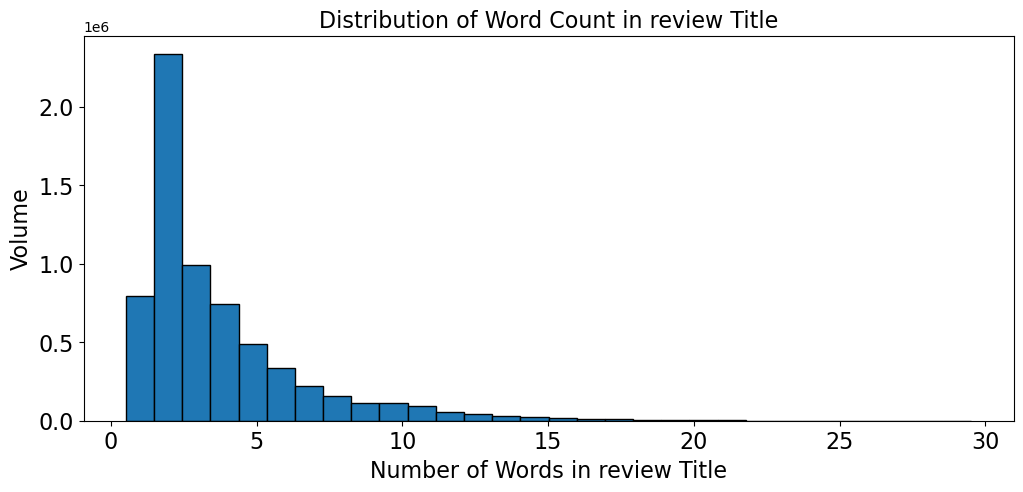

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

title_histogram = reviews_sample_token.select('title_count').rdd.flatMap(lambda x: x).histogram(30)

title_bins, title_counts = title_histogram

plt.figure(figsize=(12, 5))
plt.bar(title_bins[:-1], title_counts, width=np.diff(title_bins), edgecolor='black')
plt.xlabel('Number of Words in review Title', fontsize=16)
plt.ylabel('Volume', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Distribution of Word Count in review Title', fontsize=16)
plt.show()

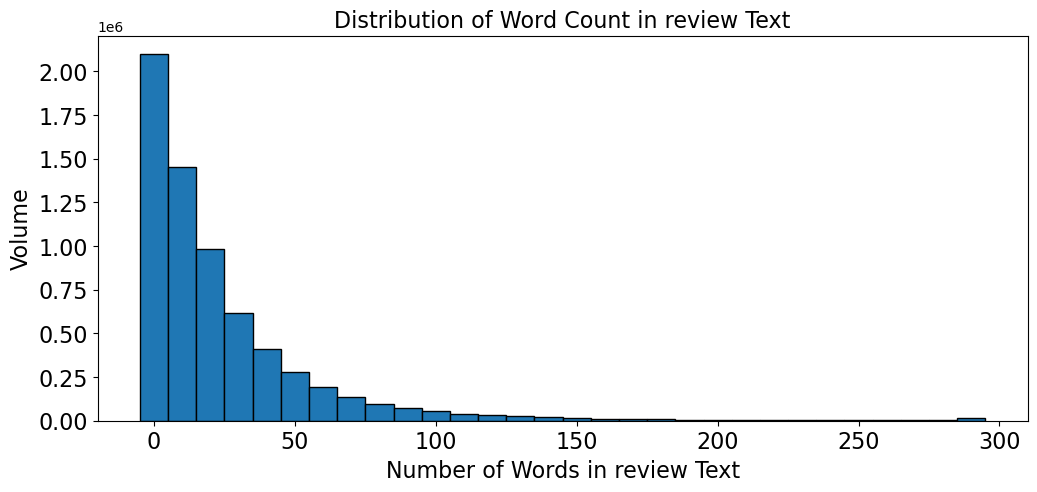

In [ ]:
text_histogram = reviews_sample_token.select('text_count').rdd.flatMap(lambda x: x).histogram(30)

text_bins, text_counts = text_histogram

plt.figure(figsize=(12, 5))
plt.bar(text_bins[:-1], text_counts, width=np.diff(text_bins), edgecolor='black')
plt.xlabel('Number of Words in review Text', fontsize=16)
plt.ylabel('Volume', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Distribution of Word Count in review Text', fontsize=16)
plt.show()

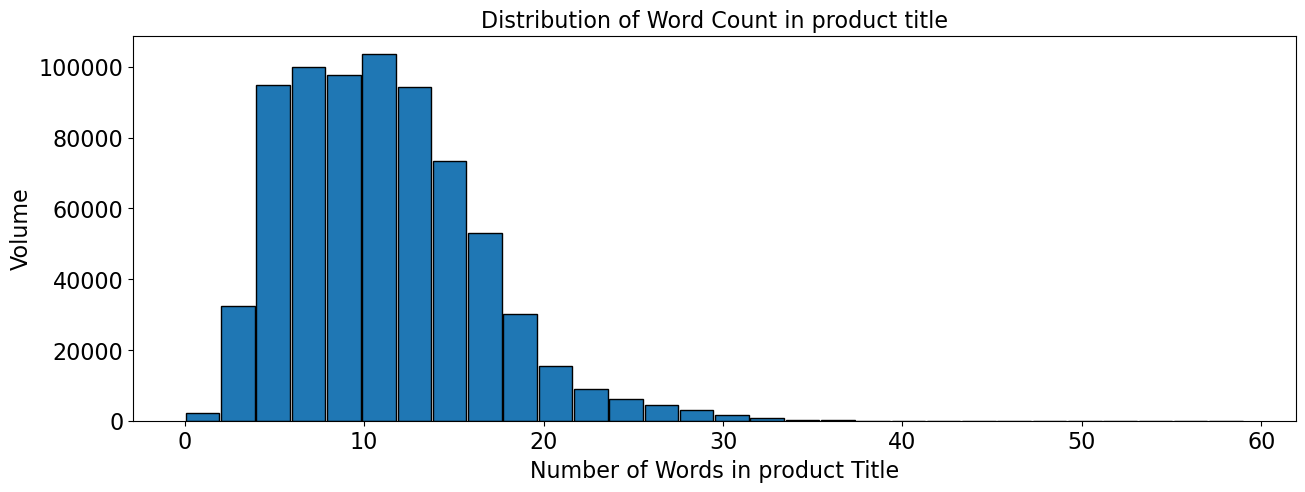

In [ ]:
meta_title_histogram = items_sample_token.select('meta_title_count').rdd.flatMap(lambda x: x).histogram(30)

meta_title_bins, meta_title_counts = meta_title_histogram

plt.figure(figsize=(15, 5))
plt.bar(meta_title_bins[:-1], meta_title_counts, width=0.95 * np.diff(meta_title_bins), edgecolor='black')
plt.xlabel('Number of Words in product Title', fontsize=16)
plt.ylabel('Volume', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Distribution of Word Count in product title', fontsize=16)
plt.show()


The three plots above show the distribution of word counts in Amazon review titles, review texts, and product names.
* Insight: It’s worth noting that most reviews are short, typically not exceeding 20 words in the text and 3 words in the title. Product titles are also quite short, with most not exceeding 10 words, contrary to common expectations.

## Distribution of Count of images in Reviews
The idea was to analyze how visual content (images) in reviews impacts user engagement or product perception.

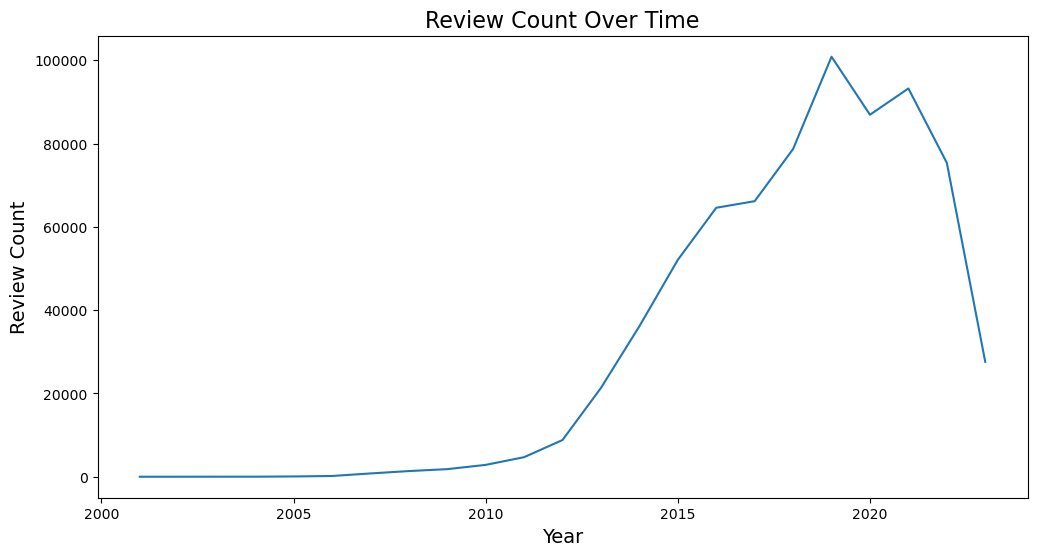

In [ ]:
time_based_analysis_pd = time_based_analysis.toPandas()

plt.figure(figsize=(12, 6))
sns.lineplot(data=time_based_analysis_pd, x="year", y="review_count")
plt.title("Review Count Over Time", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Review Count", fontsize=14)
plt.show()

## Review Count Over Time - Observe trends in reviews over the years

The graph shows a sharp increase in review counts from 2010 to 2020, peaking around 2019-2020, likely driven by the rapid growth of e-commerce and the pandemic-driven surge in online shopping. After 2020, there's a noticeable decline, which could be due to incomplete data collection, reduced consumer engagement, or stricter review policies. The trend suggests that online shopping popularity rose significantly over the last decade, but recent drops may indicate changes in consumer behavior or platform policies.

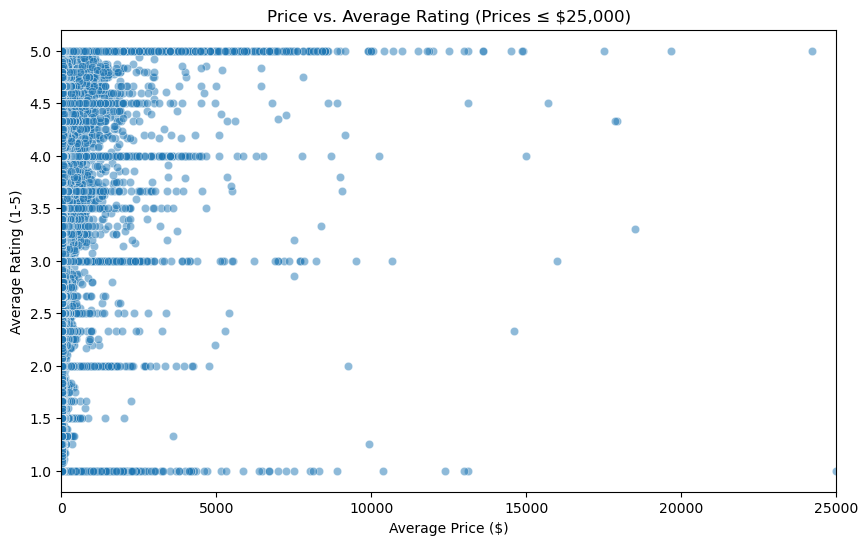

In [ ]:
#Analyzing if higher-priced items receive better ratings with a Price vs Rating analysis
from pyspark.sql import functions as F

# Join tables
combined = reviews.join(items, "parent_asin", "inner").filter(
    (F.col("price").isNotNull()) &
    (F.col("rating").isNotNull())
)

# Aggregate data
price_rating = (
    combined.groupBy("parent_asin")
    .agg(
        F.avg("price").alias("avg_price"),
        F.avg("rating").alias("avg_rating")
    )
    .filter(F.col("avg_price") <= 25000)
    .toPandas()
)

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=price_rating, x="avg_price", y="avg_rating", alpha=0.5)
plt.title("Price vs. Average Rating (Prices ≤ $25,000)")
plt.xlabel("Average Price ($)")
plt.ylabel("Average Rating (1-5)")
plt.xlim(0, 25000)
plt.show()

## Categories that dominate reviews and their performance

Top 10 highly rated Categories
Insights: High ratings (likely 4–5 stars) suggest these categories cater to dedicated audiences with specific needs like collectors, audiophiles, musicians.
Premium Beauty and Home Audio likely deliver consistent quality, driving customer satisfaction. These categories may have fewer reviews but
stronger customer loyalty.

Top 10 Most Reviewed Categories
Massive review volumes (10 million+) indicate these are high-traffic, mainstream categories.Categories like Health & Personal Care and Books are commodity and frequently purchased(no surprises there),
leading to more reviews.

Next steps: Drill into review text for high-volume categories to identify recurring issues.

## Verified Purchases vs Non Verified Purchases
Compare the proportion of Reviews from verified vs. unverified purchases.
The ideas was that If verified reviews dominate, it adds credibility to the dataset. Differences in ratings between reviews of verified and unverified purchases could indicate bias for ex: people might be incentivized to write fake reviews.

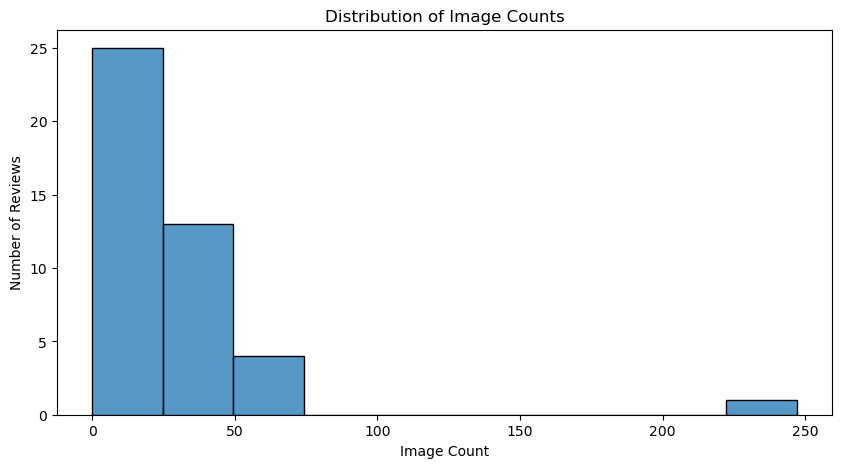

In [ ]:
# Effect of Count of Images on Reviews
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.functions import size

reviews_with_images = reviews.withColumn("image_count", size("images"))

image_stats = (
    reviews_with_images
    .groupBy("image_count")
    .count()
    .orderBy("image_count")
    .toPandas()
)

plt.figure(figsize=(10, 5))
sns.histplot(data=image_stats, x="image_count", bins=10, kde=False)
plt.title("Distribution of Image Counts")
plt.xlabel("Image Count")
plt.ylabel("Number of Reviews")
plt.show()

## Text Length Variability by Ratings

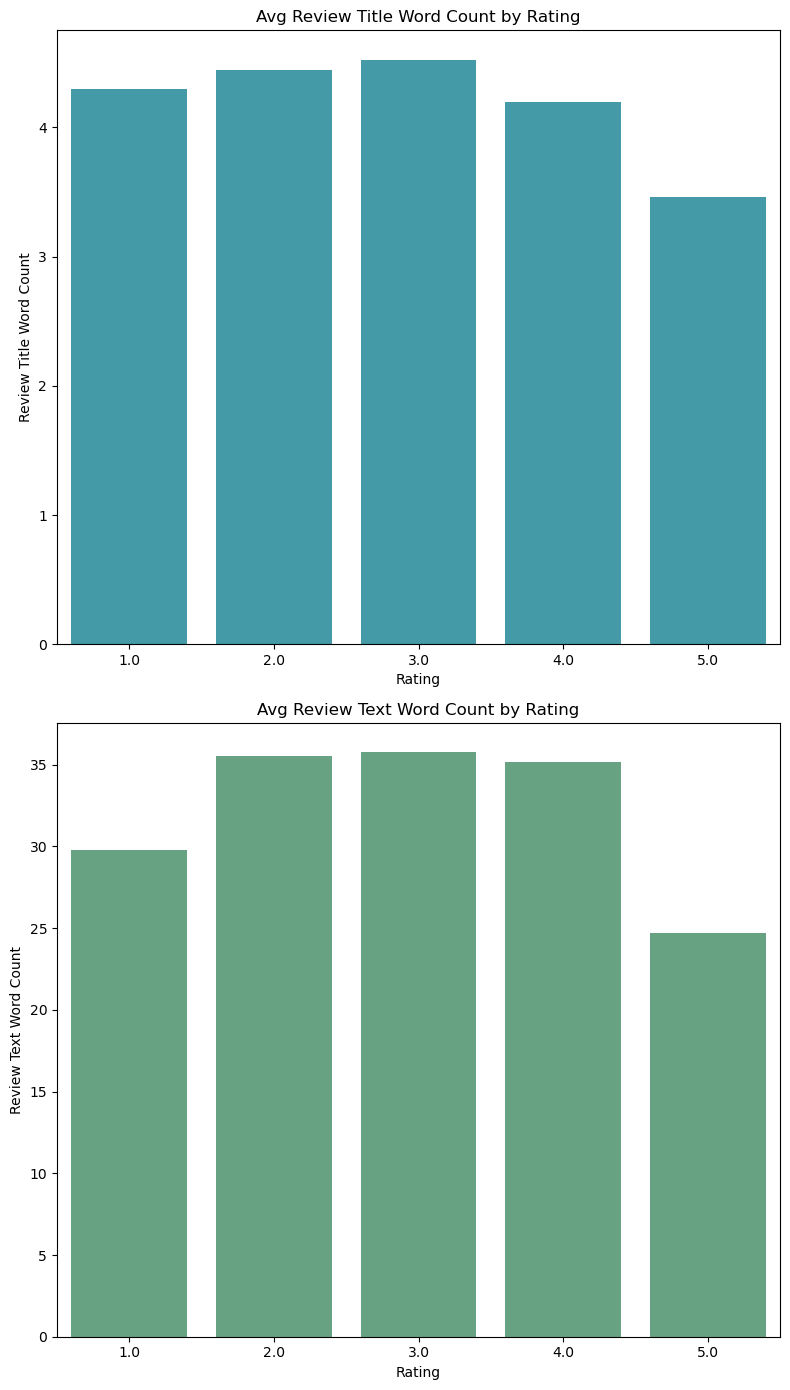

In [ ]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming combined_2pct_sample is properly defined and loaded as a Spark DataFrame
grouped_data = reviews_sample_token.groupBy("rating").agg(
    F.avg("title_count").alias("avg_title_count"),
    F.avg("text_count").alias("avg_text_count")
).orderBy("rating")

# Collecting the result to the driver node for plotting, use with caution with large datasets
result = grouped_data.collect()

# Unpacking the results into a list of dictionaries which is easy to consume by seaborn
data_to_plot = [{
    "rating": row['rating'],
    "avg_title_count": row['avg_title_count'],
    "avg_text_count": row['avg_text_count']
} for row in result]

import pandas as pd
grouped = pd.DataFrame(data_to_plot)

# Plotting the results
fig, axes = plt.subplots(2, 1, figsize=(8, 14))

# First subplot
sns.barplot(x='rating', y='avg_title_count', data=grouped, ax=axes[0], color='#33A6B8')
axes[0].set_title("Avg Review Title Word Count by Rating")
axes[0].set_xlabel("Rating")
axes[0].set_ylabel("Review Title Word Count")

# Second subplot
sns.barplot(x='rating', y='avg_text_count', data=grouped, ax=axes[1], color='#5DAC81')
axes[1].set_title("Avg Review Text Word Count by Rating")
axes[1].set_xlabel("Rating")
axes[1].set_ylabel("Review Text Word Count")

plt.tight_layout()
plt.show()

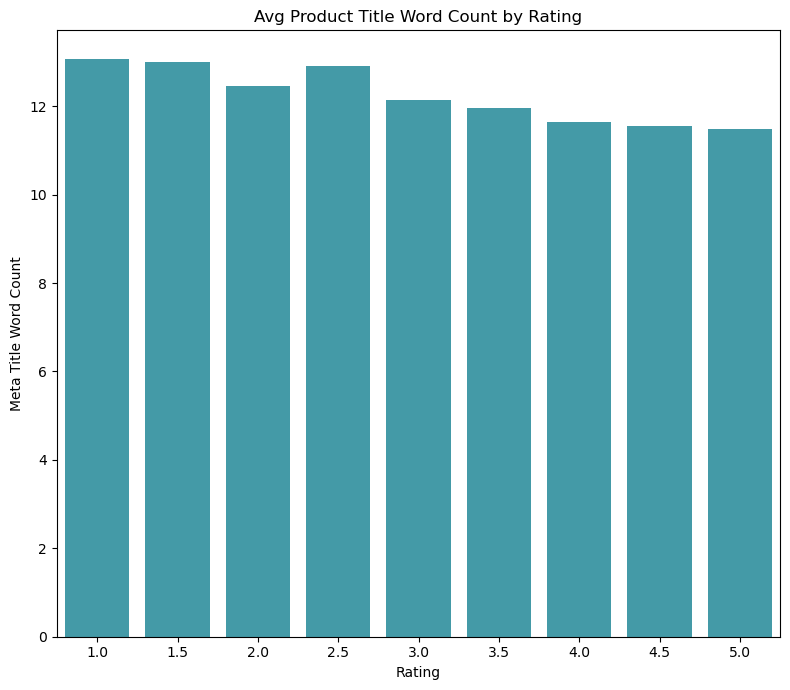

In [ ]:
items_sample_token = items_sample_token.withColumn(
    "rating",
    F.ceil(F.col("average_rating") * 2) / 2
)

# Assuming combined_2pct_sample is properly defined and loaded as a Spark DataFrame
grouped_data = items_sample_token.groupBy("rating").agg(
    F.avg("meta_title_count").alias("avg_meta_title_count")
).orderBy("rating")

# Collecting the result to the driver node for plotting, use with caution with large datasets
result = grouped_data.collect()

# Unpacking the results into a list of dictionaries which is easy to consume by seaborn
data_to_plot = [{
    "rating": row['rating'],
    "avg_meta_title_count": row['avg_meta_title_count']
} for row in result]

import pandas as pd
grouped = pd.DataFrame(data_to_plot)

# Plotting the results
fig, axes = plt.subplots(1, 1, figsize=(8, 7))

# Third subplot
sns.barplot(x='rating', y='avg_meta_title_count', data=grouped, ax=axes, color='#33A6B8')
axes.set_title("Avg Product Title Word Count by Rating")
axes.set_xlabel("Rating")
axes.set_ylabel("Meta Title Word Count")

plt.tight_layout()
plt.show()

The three plots above show the average word count in review titles and review texts across different ratings. We want to know whether Amazon customers tend to write more or less when giving different ratings.
* Insight: Reviews with a 5-star rating tend to have the fewest words, while those rated between 2 to 4 stars typically contain more textual information. This is intuitive because customers who leave such ratings may be partly satisfied with the product but also partly unsatisfied. Therefore, they have many suggestions or insights to share. Surprisingly, although we often assume that people have many complaints to express about products if they rate a specific product with 1 star, the average length of these review texts is not the longest.

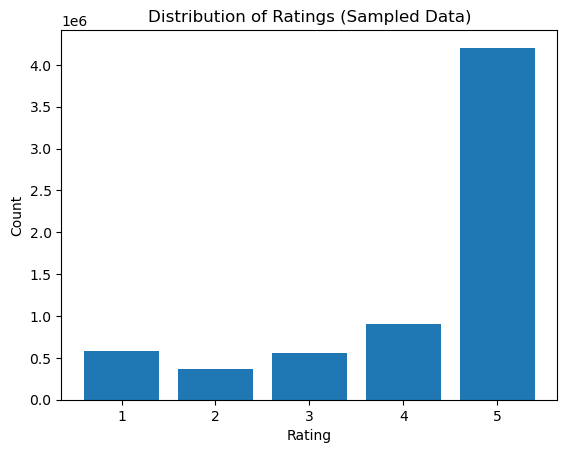

In [ ]:
# Count of Ratings vs Avg Rating. Identify the frequency of ratings (1-5 stars).
from pyspark.sql import functions as F

rating_dist = (
    reviews.sample(fraction=0.1, seed=42)
    .groupBy("rating")
    .agg(F.count("*").alias("count"))
    .orderBy("rating")
)

# Visualization
import matplotlib.pyplot as plt
plt.bar(
    rating_dist.toPandas()["rating"],
    rating_dist.toPandas()["count"]
)
plt.title("Distribution of Ratings (Sampled Data)")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

## Spread of ratings (1-5 stars) to understand overall customer satisfaction

Insight: Most reviews are clustered around 4-5 stars, indicating general customer satisfaction. 1-3 star reviews indicate recurring pain points like poor product quality or customer service.

Next Steps: Analyze text from low-rated reviews to pinpoint specific issues like "sizing" or "delivery delays".

In [ ]:
verified_summary = (
    reviews_sample.groupBy("verified_purchase")
    .agg(F.count("*").alias("count"))
    .orderBy(F.desc("count"))
)
verified_summary.show()


+-----------------+------+
|verified_purchase| count|
+-----------------+------+
|             true|662227|
|            false| 61281|
+-----------------+------+



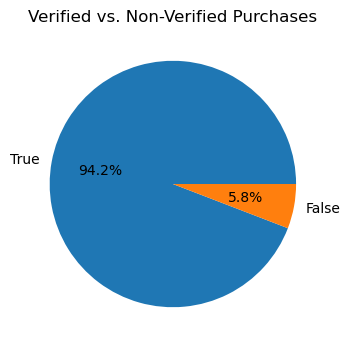

In [ ]:
# Compare the proportion of reviews (verified vs. unverified purchases)
verified_stats = reviews.groupBy("verified_purchase").count().toPandas()

plt.figure(figsize=(6, 4))
plt.pie(verified_stats["count"], labels=verified_stats["verified_purchase"], autopct="%1.1f%%")
plt.title("Verified vs. Non-Verified Purchases")
plt.show()

## Price vs Avg Rating: Do higher-priced products correlate with better ratings

While the count of 5 star ratings is pretty high for hight priced products(this could be a specific luxury brand), there is a weak Correlation Between Price and Rating.
No clear "the more expensive, the better" trend. Consumers prioritize value for money over sheer price.
Next Steps: Analyze if trends hold across categories (electronics vs. clothing). Luxury categories may defy the pattern. Text Analysis of Low-Rated Expensive Items:
Extract keywords from negative reviews of high-priced products

/tmp/ipykernel_12409/1817382117.py:23: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_pd.head(10), y='main_category', x='average_rating', palette="viridis")
/tmp/ipykernel_12409/1817382117.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_pd.sort_values('total_reviews', ascending=False).head(10),


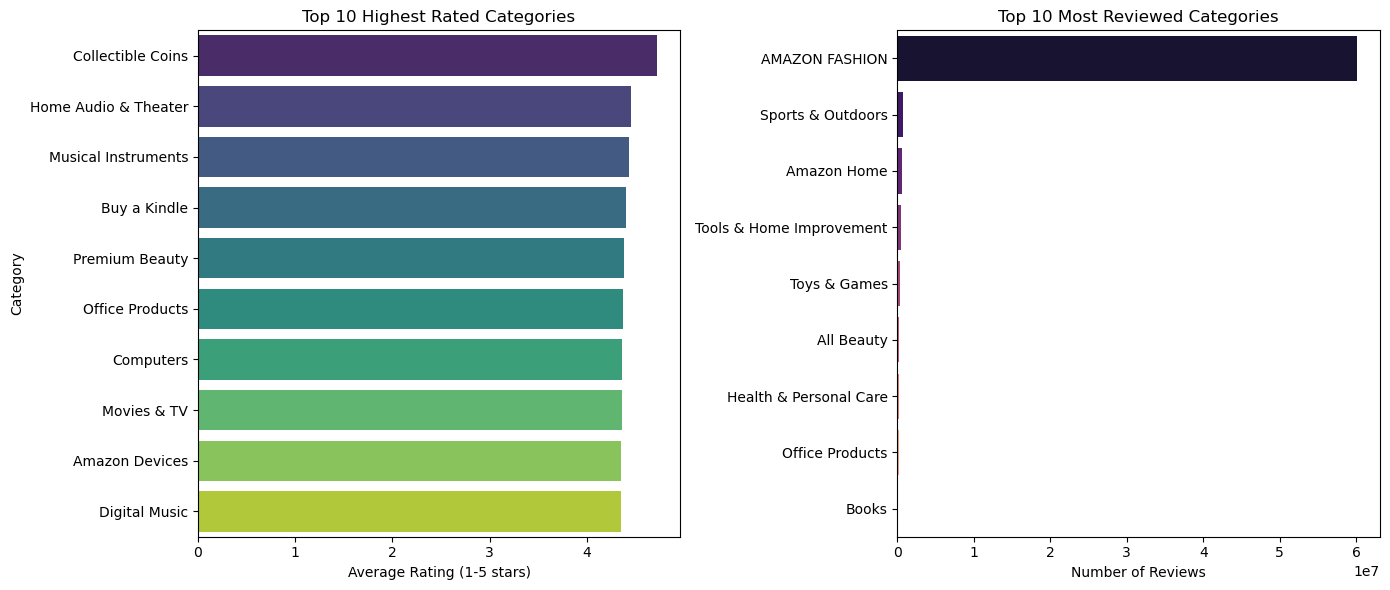

In [ ]:
# Understanding Categories with highest average ratings, popular categories
# Join
combined = reviews.join(items, "parent_asin", "inner")

# Calculate average rating and number of reviews per category
category_stats = (
    combined.groupBy("main_category")
    .agg(
        F.avg("rating").alias("average_rating"),
        F.count("*").alias("total_reviews")
    )
    .filter(F.col("total_reviews") > 100)
    .orderBy(F.desc("average_rating"))
)

category_pd = category_stats.toPandas()

#Visualization
plt.figure(figsize=(14, 6))

# Plot 1: Average Ratings by Category
plt.subplot(1, 2, 1)
sns.barplot(data=category_pd.head(10), y='main_category', x='average_rating', palette="viridis")
plt.title("Top 10 Highest Rated Categories")
plt.xlabel("Average Rating (1-5 stars)")
plt.ylabel("Category")

# Plot 2: Most Reviewed Categories (Pouplarity)
plt.subplot(1, 2, 2)
sns.barplot(data=category_pd.sort_values('total_reviews', ascending=False).head(10),
           y='main_category', x='total_reviews', palette="magma")
plt.title("Top 10 Most Reviewed Categories")
plt.xlabel("Number of Reviews")
plt.ylabel("")

plt.tight_layout()
plt.show()

In [ ]:
from pyspark.sql import functions as F

rating_summary = (
    reviews_sample.groupBy("rating")
    .agg(F.count("*").alias("count"))
    .orderBy("rating")
)
rating_summary.show()


+------+------+
|rating| count|
+------+------+
|   1.0| 68600|
|   2.0| 43845|
|   3.0| 68859|
|   4.0|108652|
|   5.0|433552|
+------+------+



In [ ]:
helpful_summary = (
    reviews_sample.groupBy("helpful_vote")
    .agg(F.count("*").alias("count"))
    .orderBy(F.desc("count"))
    .limit(10)
)
helpful_summary.show()


+------------+------+
|helpful_vote| count|
+------------+------+
|           0|567308|
|           1| 91123|
|           2| 28763|
|           3| 12862|
|           4|  6904|
|           5|  4242|
|           6|  2717|
|           7|  1838|
|           8|  1327|
|           9|   963|
+------------+------+



In [ ]:
popularity_satisfaction = (
    reviews_sample.groupBy("parent_asin")
    .agg(
        F.count("*").alias("review_count"),
        F.avg("rating").alias("avg_rating"),
        F.sum("helpful_vote").alias("total_helpful_votes")
    )
    .orderBy(F.desc("review_count"))
)
popularity_satisfaction.show(10)


+-----------+------------+----------+-------------------+
|parent_asin|review_count|avg_rating|total_helpful_votes|
+-----------+------------+----------+-------------------+
| B000ALB1M0|           1|       4.0|                  0|
| B0000TIIBE|           1|       3.0|                  1|
| B0002V32NE|           1|       5.0|                  0|
| B000A700PI|           1|       4.0|                  0|
| B000B36C4O|           1|       5.0|                  0|
| B000JX1W46|           1|       5.0|                  4|
| B000B4ZXW0|           1|       2.0|                  1|
| B000NGKLDW|           1|       2.0|                  1|
| B000792JU8|           1|       5.0|                  1|
| B000XRW1ZM|           1|       5.0|                  0|
+-----------+------------+----------+-------------------+
only showing top 10 rows



In [ ]:
time_based_analysis = (
    reviews_sample.withColumn("year", F.year("timestamp"))
    .groupBy("year")
    .agg(
        F.count("*").alias("review_count"),
        F.avg("rating").alias("avg_rating")
    )
    .orderBy("year")
)
time_based_analysis.show()


+----+------------+------------------+
|year|review_count|        avg_rating|
+----+------------+------------------+
|2001|           2|               3.0|
|2002|           2|               5.0|
|2003|           7| 4.857142857142857|
|2004|          10|               4.7|
|2005|          67| 4.074626865671642|
|2006|         176|4.0852272727272725|
|2007|         788| 4.225888324873097|
|2008|        1359| 4.146431199411332|
|2009|        1822|4.1684961580680575|
|2010|        2843| 4.137530777347872|
|2011|        4695| 4.111395101171459|
|2012|        8816| 4.157214156079855|
|2013|       21324| 4.187206903020071|
|2014|       36135|  4.20246298602463|
|2015|       52070| 4.220856539274054|
|2016|       64583| 4.213570134555533|
|2017|       66163| 4.190045795988695|
|2018|       78697| 4.154592932386241|
|2019|      100849| 4.136273041874485|
|2020|       86917| 4.096114684123934|
+----+------------+------------------+
only showing top 20 rows



# Summary of Preliminary Analysis

Amazon reviews are characteristically concise: review texts typically comprise fewer than 20 words, titles average around 3 words, and product names rarely exceed 10 words. Notably, review length varies with the rating; five-star reviews tend to be succinct, whereas reviews rated between two and four stars are more verbose—potentially reflecting a blend of satisfaction and dissatisfaction—although one-star reviews do not exhibit the greatest word counts. Overall, the majority of reviews are clustered around four to five stars, with lower ratings frequently indicating recurring concerns related to product quality or customer service.

Over time, review volumes increased markedly from 2010, peaking around 2019–2020—a trend likely driven by the rise in e-commerce and shifts in consumer behavior during the pandemic—before declining post-2020, possibly due to changes in consumer engagement or review policies. Furthermore, the correlation between price and rating appears weak, suggesting that consumers prioritize value for money over cost alone. Analysis of category-specific trends reveals that while highly rated segments attract a dedicated, niche audience, mainstream categories such as Health & Personal Care and Books generate a significant volume of reviews, warranting further text analysis to identify prevalent issues.

# Machine Learning Techniques

## Association Rules

Hypothesis: If a product receives a 5-star rating and is marked as a verified purchase, then it is likely to have a detailed review (more than 50 words). Alternatively if the product recieves <2 -star rating, then it is likely to have a detailed review expressing discontent and frustration.

Both these hypothesis are proven wrong below.

In [ ]:
from pyspark.sql.functions import col, when, size, split

# Step 1: Create categorical columns for review attributes
reviews_enriched = reviews.withColumn(
    "rating_category",
    when(col("rating") == 5, "High Rating").otherwise("Other Rating")
).withColumn(
    "verified_category",
    when(col("verified_purchase") == True, "Verified").otherwise("Not Verified")
).withColumn(
    "word_count",
    size(split(col("text"), " "))   # Count the number of words in the review text
).withColumn(
    "detail_category",
    when(col("word_count") > 50, "Detailed Review").otherwise("Short Review")
)


# Step 2: Focus on reviews that are 5-star and marked as Verified
high_verified_reviews = reviews_enriched.filter(
    (col("rating_category") == "High Rating") &
    (col("verified_category") == "Verified")
)

# Step 3: Group by the detail_category (whether the review is detailed or short)
# and count how many reviews fall into each bucket.
association_counts = high_verified_reviews.groupBy("detail_category").count()

# Display the results
association_counts.show()

In [ ]:
from pyspark.sql.functions import col, when, size, split

# Step 1: Create categorical columns for review attributes.
reviews_enriched = reviews.withColumn(
    "rating_category",
    when(col("rating") < 2, "Low Rating").otherwise("Other Rating")
).withColumn(
    "word_count",
    size(split(col("text"), " "))
).withColumn(
    "detail_category",
    when(col("word_count") > 50, "Detailed Review").otherwise("Short Review")
)

# Step 2: Filter the reviews for those with less than 2 stars.
low_rating_reviews = reviews_enriched.filter(col("rating_category") == "Low Rating")

# Step 3: Group by the detail_category (Detailed vs. Short) and count the number of reviews.
low_rating_counts = low_rating_reviews.groupBy("detail_category").count()

# Display the result.
low_rating_counts.show()


Review Length vs Helpful Vote. If a review is detailed (has more than 100 words) and is from a verified purchase, then it is likely to receive a high number of helpful votes.

Rationale & Benefits: This rule could help identify the types of reviews that are most valuable to future customers. Understanding this association might encourage prompting users (or designing review layouts) to include more details since detailed reviews are seen as more reliable.If the goal is to provide helpful feedback for future customers, nudging users to leave more detailed reviews could increase the overall helpfulness score.

In [ ]:
from pyspark.sql.functions import col, when, split, size, avg, count

# Step 1: Enrich the reviews DataFrame:
reviews_enriched = reviews.withColumn(
    "word_count", size(split(col("text"), " "))
).withColumn(
    "detail_category",
    when(col("word_count") > 100, "Detailed Review").otherwise("Short Review")
).withColumn(
    "verified_status",
    when(col("verified_purchase") == True, "Verified").otherwise("Non-Verified")
)

# Step 2: Filter to include only reviews from verified purchases.
verified_reviews = reviews_enriched.filter(col("verified_status") == "Verified")

# Step 3: Group the verified reviews by the detail_category and calculate:
review_helpfulness = verified_reviews.groupBy("detail_category").agg(
    avg("helpful_vote").alias("average_helpful_votes"),
    count("*").alias("review_count")
)

# Display the results.
review_helpfulness.show()

Hypothesis: If a product is in a higher price range, then reviews tend to be more detailed regardless of star rating.

Rationale & Benefits: Customers purchasing expensive items may invest more thought into their reviews because of the higher risk or investment value.

This insight can help retailers target customers with premium products by encouraging more in-depth feedback and leveraging those detailed reviews in marketing materials. It might also help segment products by price and adjust customer follow-up strategies (such as asking for more detailed feedback on higher-priced purchases).


In [ ]:
from pyspark.sql.functions import col, when, split, size, avg, count

# Step 1: Enrich Reviews with Word Count and Detail Category
reviews_enriched = reviews.withColumn(
    "word_count", size(split(col("text"), " "))
).withColumn(
    "detail_category",
    when(col("word_count") > 100, "Detailed Review").otherwise("Short Review")
)

# Step 2: Join Reviews with Products (items) to Access Price Information
combined = reviews_enriched.join(
    items.select("parent_asin", "price"),
    on="parent_asin",
    how="inner"
)

# Step 3: Create Price Buckets
combined = combined.withColumn(
    "price_range",
    when(col("price") < 50, "Low Price")
    .when((col("price") >= 50) & (col("price") < 150), "Medium Price")
    .otherwise("High Price")
)

# Step 4: Group the Data and Analyze Review Detail by Price Range
detail_distribution = combined.groupBy("price_range", "detail_category").agg(
    count("*").alias("review_count")
).orderBy("price_range")

print("Review count distribution by price range and review detail:")
detail_distribution.show()

# Compute additional statistics like average word count and the proportion of detailed reviews for each price bucket.
price_insights = combined.groupBy("price_range").agg(
    avg("word_count").alias("avg_word_count"),
    (count(when(col("detail_category") == "Detailed Review", True)) / count("*")).alias("detailed_percentage")
)

print("Price range insights:")
price_insights.show()


Category Mix: The Medium Price bracket may contain categories (electronics, apparel) that prompt more explanation than certain high-priced categories (niche luxury items).

Buyer Profile: Shoppers in the medium range might be more compelled to justify or explain their purchase decisions.

Hypothesis: If reviews are submitted during certain time periods (during a promotional event or a holiday season), then they might tend to be more positive (or possibly more negative) and detailed.

Rationale & Benefits: Seasonal trends can influence buyer sentiment and behavior.


In [ ]:
from pyspark.sql.functions import month, avg, count

# Extract the month from the timestamp and create a new column 'review_month'
reviews_monthly = reviews.withColumn("review_month", month("timestamp"))

# Group by the review month (ignoring the year) and aggregate average rating and count of reviews.
monthly_aggregate = reviews_monthly.groupBy("review_month") \
    .agg(
        avg("rating").alias("avg_rating"),
        count("*").alias("review_count")
    ) \
    .orderBy("review_month")

# Display the aggregated results.
monthly_aggregate.show()

Hypothesis: If a customer leaves detailed reviews for products in one category, then they are likely to leave detailed reviews in other categories.

Rationale & Benefits: Identifying “power reviewers” or prolific feedback providers may help in personalizing recommendations.

## Sentiment Analysis & Topic Modeling

In [ ]:
from pyspark.sql.functions import col, when

# Only keep rows with review text and rating
df_clean = df_sampled.filter(col("reviewText").isNotNull() & col("overall").isNotNull())

# Create binary sentiment label: 1 = positive, 0 = negative
df_labeled = df_clean.withColumn("label", when(col("overall") >= 4, 1).otherwise(0))

# Keep only the necessary columns
df_labeled = df_labeled.select("reviewText", "label")

# Show some labeled rows
df_labeled.show(5, truncate=100)

+----------------------------------------------------------------------------------------------------+-----+
|                                                                                          reviewText|label|
+----------------------------------------------------------------------------------------------------+-----+
|I already own this particular Shining Image jewelry box in brown, so this was my second buy. It a...|    0|
|Bought for my 4 year old granddaughter to keep for years. My wife loved it! I'm sure it will be w...|    1|
|Perfect size and came with cute little light up &#34;Speak Now&#34; magnets :] This will be the p...|    1|
|I'm a linguist by training, with a focus in how people learn languages.  The concept behind Roset...|    0|
|Great album Larry, it sure brings back the memories of the Six years spent on the island especial...|    1|
+----------------------------------------------------------------------------------------------------+-----+
only showing top 5 

In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF

# Tokenize the text into words
tokenizer = Tokenizer(inputCol="reviewText", outputCol="words")

# Remove common stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered")


In [ ]:

# Convert to term frequency vector
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=10000)

# Scale using inverse document frequency
idf = IDF(inputCol="rawFeatures", outputCol="features")

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

# Logistic Regression for binary classification
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Full pipeline: NLP + ML
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, lr])


In [ ]:
# Split into training and test data
train_data, test_data = reviews_labeled.randomSplit([0.8, 0.2], seed=42)

# Fit the pipeline to the training data
model = pipeline.fit(train_data)


In [ ]:
# Run predictions on the test set
predictions = model.transform(test_data)

# Show predictions with actual labels
predictions.select("reviewText", "label", "prediction", "probability").show(10, truncate=100)


+----------------------------------------------------------------------------------------------------+-----+----------+-------------------------------------------+
|                                                                                          reviewText|label|prediction|                                probability|
+----------------------------------------------------------------------------------------------------+-----+----------+-------------------------------------------+
|                                                                                                    |    1|       1.0|   [0.23098101049825018,0.7690189895017499]|
|"It's awesome!", that's what the boy for whom this costume was a gift said when he saw it.  He lo...|    1|       1.0|[4.3311591109038574E-14,0.9999999999999567]|
|"The Eyes" t-shirt is a beauty!  I love the vibrant purple color and I get lots of compliments on...|    1|       1.0| [7.276680184954224E-14,0.9999999999999273]|
|"ex" has been l

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"ROC-AUC Score: {auc:.4f}")


ROC-AUC Score: 0.7847


In this analysis, we processed Amazon product reviews to build a binary sentiment classifier. We labeled the reviews as positive or negative based on the review ratings and prepared the text for machine learning by tokenizing, removing stopwords, and applying TF-IDF feature extraction.
Using a logistic regression model within a Spark ML pipeline, we trained the classifier and evaluated its performance. When applied to unseen test data, the model was able to predict the sentiment of reviews with reasonable accuracy, showing clear and logical predictions in line with the actual labels. Sample predictions confirmed that reviews with positive language and higher ratings were accurately classified as positive (label 1), and similarly for negative ones (label 0). The evaluation yielded a ROC-AUC score of approximately 0.7847, indicating good model performance.

LDA

In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer

# Tokenize
tokenizer = Tokenizer(inputCol="reviewText", outputCol="words")
df_tokenized = tokenizer.transform(df_sampled)

# Remove stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
df_filtered = remover.transform(df_tokenized)

# CountVectorizer → required for LDA (not TF or HashingTF)
cv = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=5000, minDF=5)
cv_model = cv.fit(df_filtered)
df_ready = cv_model.transform(df_filtered)


In [ ]:
from pyspark.ml.clustering import LDA

# Let's extract 5 topics (you can increase later)
lda = LDA(k=5, maxIter=10, featuresCol="features")
lda_model = lda.fit(df_ready)


In [ ]:
# Show top 10 words for each topic
topics = lda_model.describeTopics(10)
vocab = cv_model.vocabulary

# Decode the word indices into real words
topics_words = topics.rdd.map(lambda row: [vocab[idx] for idx in row['termIndices']])
topics_words.collect()


[['ring',
  '',
  'like',
  'quality',
  'looks',
  'good',
  'size',
  'color',
  'love',
  'beautiful'],
 ['',
  'watch',
  'like',
  'looks',
  'great',
  'good',
  'really',
  'time',
  'watch.',
  'little'],
 ['',
  'size',
  'like',
  'fit',
  'wear',
  'love',
  'shoes',
  'one',
  'great',
  'little'],
 ['', 'little', 'like', '&', 'one', 'wear', '.', 'got', 'well', 'great'],
 ['',
  'great',
  'love',
  'good',
  'like',
  'one',
  'bought',
  'it.',
  'fit',
  'really']]

In [ ]:
df_topics = lda_model.transform(df_ready)


In [ ]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType

# Topic label mapping
topic_labels = {
    0: "Aesthetics & Quality",
    1: "Watches / Appearance",
    2: "Fit & Comfort",
    3: "Small-size Experience",
    4: "General Positivity"
}

# UDF to convert topic number to label
get_topic_label_udf = udf(lambda tid: topic_labels.get(tid, "Unknown"), StringType())

# Add the label column
df_topics_labeled = df_topics_labeled.withColumn("topicLabel", get_topic_label_udf(col("topic")))


In [ ]:
# Group and count the number of reviews per topic
topic_counts_df = df_topics_labeled.groupBy("topicLabel").count().orderBy("count", ascending=False)

# Show the result to make sure it's working
topic_counts_df.show()


+--------------------+-----+
|          topicLabel|count|
+--------------------+-----+
|       Fit & Comfort|28081|
|  General Positivity|19499|
|Watches / Appearance| 6257|
|Aesthetics & Quality| 2130|
|Small-size Experi...| 1867|
+--------------------+-----+



In [ ]:
topic_counts = topic_counts_df.toPandas()


/tmp/ipykernel_17123/1660000597.py:12: UserWarning: Glyph 128095 (\N{ATHLETIC SHOE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_17123/1660000597.py:12: UserWarning: Glyph 128150 (\N{SPARKLING HEART}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_17123/1660000597.py:12: UserWarning: Glyph 8986 (\N{WATCH}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_17123/1660000597.py:12: UserWarning: Glyph 128141 (\N{RING}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_17123/1660000597.py:12: UserWarning: Glyph 129295 (\N{PINCHING HAND}) missing from current font.
  plt.tight_layout()
/opt/conda/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128095 (\N{ATHLETIC SHOE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128150 (\N{SPARKLING HEART}) missing from current fo

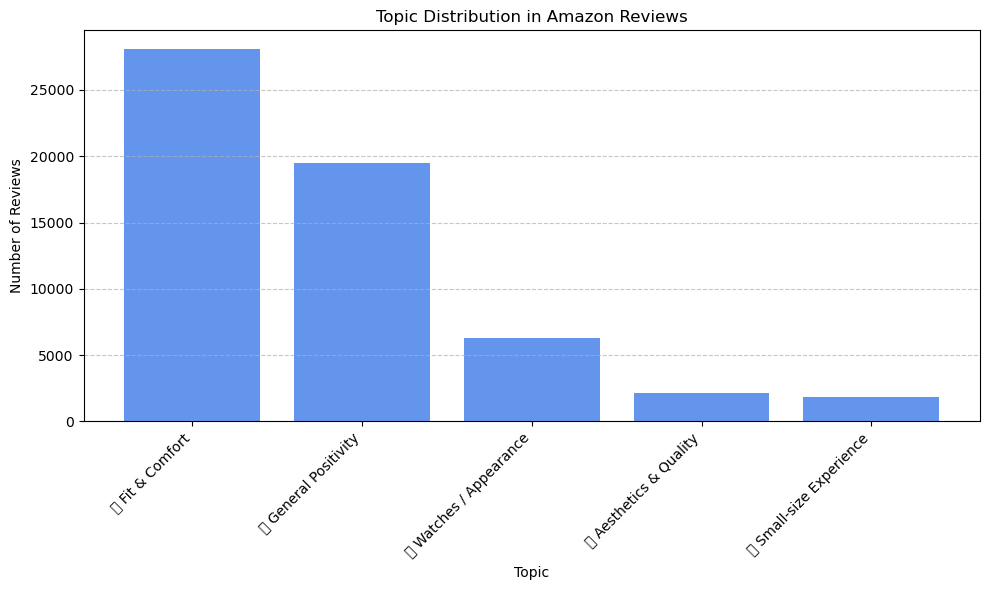

In [ ]:
import matplotlib.pyplot as plt

# Make the bar chart
plt.figure(figsize=(10, 6))
plt.bar(topic_counts['topicLabel'], topic_counts['count'], color='cornflowerblue')

# Formatting
plt.xticks(rotation=45, ha='right')
plt.title("Topic Distribution in Amazon Reviews")
plt.ylabel("Number of Reviews")
plt.xlabel("Topic")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


Through topic modeling of customer reviews using Latent Dirichlet Allocation (LDA), we uncovered the major themes customers focus on when discussing clothing, footwear, and accessories. The most dominant theme by far was Fit and Comfort, emphasizing how crucial proper sizing and product fit are to overall satisfaction. This suggests that enhancing size guidance tools and offering personalized fit recommendations could significantly improve customer happiness and reduce product return rates. The second most common theme was General Positivity, where thousands of reviews used terms like "love" and "great," presenting strong opportunities for extracting testimonials and reinforcing brand marketing strategies.

Beyond these, smaller yet important topics emerged around Appearance and Quality, particularly for watches, jewelry, and other accessories, highlighting the need for high-quality visuals. Additionally, niche topics around size issues and expectation mismatches suggest areas where brands could further refine product information or manage customer expectations more effectively.

Overall, this analysis not only provides deep insights into customer priorities but also points to actionable opportunities for improving product listings, enhancing the customer experience, and leveraging authentic customer language to guide business decisions.

## Cluster Analysis with TF-IDF (Will reviews with different ratings naturally cluster together?)

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, BooleanType, FloatType, ArrayType, LongType
from pyspark.sql.functions import col, from_unixtime

# Read sample
reviews_sample = spark.read.parquet("gs://jhuangbp-ba843-spring25/output/reviews_sample").cache()
items_sample = spark.read.parquet("gs://jhuangbp-ba843-spring25/output/items_sample").cache()

reviews_sample.count()
items_sample.count()

reviews_sample.show(5)
items_sample.show(5)



+------+--------------------+--------------------+------+----------+-----------+--------------------+-------------------+-----------------+------------+
|rating|               title|                text|images|      asin|parent_asin|             user_id|          timestamp|verified_purchase|helpful_vote|
+------+--------------------+--------------------+------+----------+-----------+--------------------+-------------------+-----------------+------------+
|   5.0|           Great Buy|I usually purchas...|    []|B01B8B9T1A| B01B8B9T1A|AGCXTIIVTZ2GUOLEP...|2016-07-16 15:55:22|             true|           2|
|   4.0|          Four Stars|Just get a size l...|    []|B00B81ILGK| B00B81ILGK|AERVH3JISJEJADTBG...|2015-03-18 04:46:31|             true|           0|
|   4.0|Solid Every-other...|Nothing too fancy...|    []|B003ICWK3C| B003ICWK6O|AFJ5HAGE5Y5WZGPPS...|2012-12-21 22:38:13|             true|           0|
|   5.0|       Won't Regret.|I love myself som...|    []|B004PYWOQA| B004PYYAYY|AF

Use TF-IDF to transform review text into vectors for further analysis.

In [ ]:
from pyspark.sql import functions as F
from pyspark.ml.feature import RegexTokenizer, Tokenizer, HashingTF, IDF
from pyspark.ml import Pipeline

reviews_sample_cleaned = reviews_sample.withColumn("clean_text", F.lower(F.regexp_replace(F.col("text"), "[^a-zA-Z\\s]", "")))

# Step 2: Tokenize using regex (split on non-word characters)
regex_tokenizer = RegexTokenizer(
    inputCol="clean_text",
    outputCol="tokens",
    pattern="\\W+",         # split on anything that's not a word character
    minTokenLength=1,
    toLowercase=False       # already lowercased in clean_text
)

# Step 3: Convert tokens to term-frequency vectors via hashing
hashingTF = HashingTF(inputCol="tokens", outputCol="rawFeatures", numFeatures=1000)

# Step 4: Compute IDF weights
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Step 5: Build the pipeline
pipeline = Pipeline(stages=[regex_tokenizer, hashingTF, idf])

# Step 6: Fit pipeline on cleaned data
model = pipeline.fit(reviews_sample_cleaned)

# Step 7: Transform to get TF-IDF features
reviews_sample_tfidf = model.transform(reviews_sample_cleaned)




In [ ]:
reviews_sample_tfidf = reviews_sample_tfidf.cache()
reviews_sample_tfidf.count()

25/04/25 18:35:17 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_55_3 !
25/04/25 18:35:17 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_19_4 !
25/04/25 18:35:17 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_7_10 !
25/04/25 18:35:17 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_19_2 !
25/04/25 18:35:17 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_7_14 !
25/04/25 18:35:17 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_55_7 !
25/04/25 18:35:17 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_7_2 !
25/04/25 18:35:17 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_19_0 !
25/04/25 18:35:17 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_55_6 !
25/04/25 18:35:17 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_55_10 !
25/04/25 18:35:17 WARN BlockManagerMasterEndpoint: No more replicas av

6604778

Different colors were used to represent data points with different ratings, aiming to explore whether different ratings correspond to distinct review contexts. If the results had shown that data points with the same rating clustered naturally, it would have supported this hypothesis. Unfortunately, both the PCA and SVD 3D plots showed that data points with different ratings are mixed together, which contradicts my assumption.

In [ ]:
from pyspark.ml.feature import StandardScaler as SparkStandardScaler, PCA as SparkPCA
from pyspark.ml import Pipeline

scaler = SparkStandardScaler(
    inputCol="features",
    outputCol="scaled_features",
    withMean=True,
    withStd=True
)
pca = SparkPCA(
    k=3,
    inputCol="scaled_features",
    outputCol="pca_features"
)

pipeline = Pipeline(stages=[scaler, pca])


model = pipeline.fit(reviews_sample_tfidf)
reviews_sample_pca = model.transform(reviews_sample_tfidf)
reviews_sample_pca.select("pca_features","rating").show(truncate=False)


+-------------------------------------------------------------+------+
|pca_features                                                 |rating|
+-------------------------------------------------------------+------+
|[-3.384718197072014,0.5333634793484522,-0.6723596237015674]  |5.0   |
|[2.693912575909261,0.3690039260412888,-0.31735068660154064]  |4.0   |
|[-1.5205367100262455,0.6715411024147332,0.6400944174897771]  |4.0   |
|[-0.03996486552452955,-0.22978462403934288,1.014997013907074]|5.0   |
|[1.4186552639689796,2.6405624753989048,0.8372177857273602]   |5.0   |
|[2.6027833100794284,-0.7998782815137268,0.18798293087431478] |4.0   |
|[2.418037130240078,1.1419950260302945,0.6287614382698612]    |1.0   |
|[3.76064667113992,-0.10754892459421647,0.4004376488913054]   |5.0   |
|[2.6312158446111176,-1.3550454050242655,0.11966603470322787] |5.0   |
|[-1.4485208111728682,2.611913060793242,-0.03720809412303361] |4.0   |
|[3.409770693307964,-0.18055421556419352,0.1200191571902617]  |5.0   |
|[1.19

In [ ]:
from pyspark.sql import Window
from pyspark.sql.functions import rand, row_number
from pyspark.ml.functions import vector_to_array
import os
cwd = os.getcwd()
local_path = os.path.join(cwd, "reviews_sample_pca.csv")

w = Window.partitionBy("rating").orderBy(rand())
sampled = (
    reviews_sample_pca
    .withColumn("rn", row_number().over(w))
    .filter("rn <= 20")
    .drop("rn")
)

df_arr = sampled.withColumn("arr", vector_to_array("pca_features"))
df_pca = df_arr.selectExpr(
    "arr[0] as PC1",
    "arr[1] as PC2",
    "arr[2] as PC3",
    "rating as label"
)

pdf = df_pca.toPandas()


In [ ]:
!pip install plotly==5.24.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 91.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: plotly
    Found existing installation: plotly 6.0.1
    Uninstalling plotly-6.0.1:
      Successfully uninstalled plotly-6.0.1


In [ ]:
import plotly.express as px
import os

pdf['label'] = pdf['label'].astype(str)

# Plotting
fig = px.scatter_3d(
    pdf,
    x='PC1',
    y='PC2',
    z='PC3',
    color='label',
    hover_name="label",
    opacity=0.5,
    color_discrete_sequence=px.colors.qualitative.Set2
)
fig.update_traces(marker=dict(size=3))

# Save plot as HTML for debugging
fig.write_html("pca_plot.html")
print("Plot saved as pca_plot.html")

# Show plot
fig.show()

Plot saved as pca_plot.html


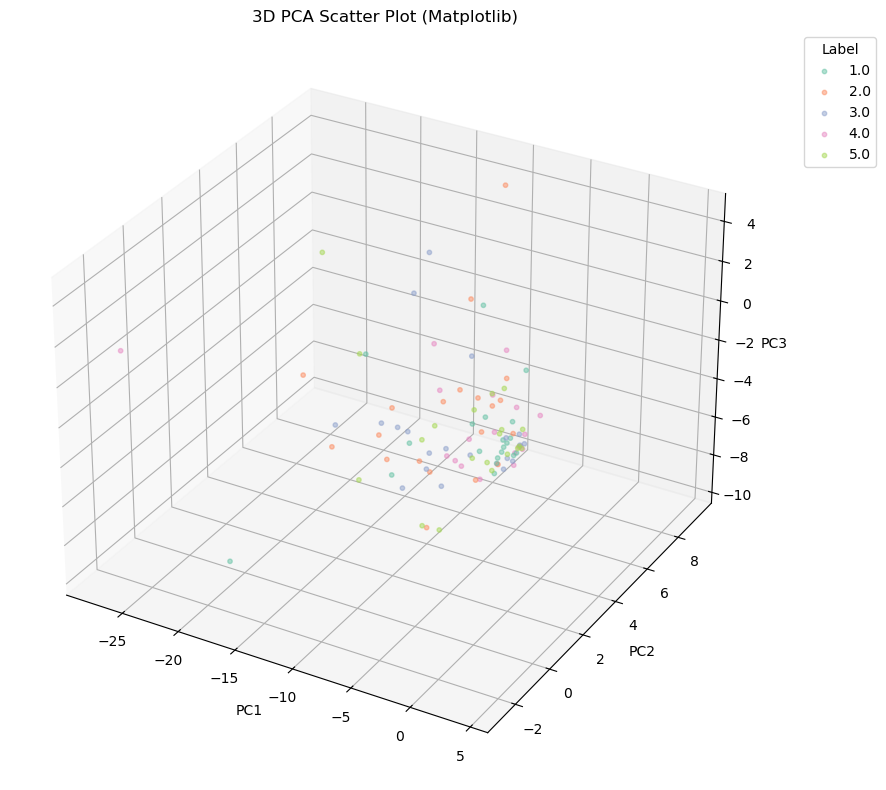

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

pdf['label'] = pdf['label'].astype(str)


unique_labels = pdf['label'].unique()
colors = plt.cm.Set2(range(len(unique_labels)))


label_color_dict = {label: colors[i] for i, label in enumerate(unique_labels)}


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label in unique_labels:
    subset = pdf[pdf['label'] == label]
    ax.scatter(
        subset['PC1'],
        subset['PC2'],
        subset['PC3'],
        label=label,
        s=10,
        alpha=0.5,
        color=label_color_dict[label]
    )

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title('3D PCA Scatter Plot (Matplotlib)')

plt.tight_layout()
plt.show()


In [ ]:
from pyspark.sql import Window
from pyspark.sql.functions import col, rand, row_number
from pyspark.storagelevel import StorageLevel
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix

reviews_sample_tfidf2 = reviews_sample_tfidf.sample(fraction=0.1, seed=42)

rdd_vectors = (
    reviews_sample_tfidf2
      .select("features")
      .rdd
      .map(lambda row: Vectors.fromML(row[0]))
      .cache()
)
rdd_vectors.count()

k = 3
svd = RowMatrix(rdd_vectors).computeSVD(k, computeU=True)

U_df = (
    svd.U.rows
      .zipWithIndex()
      .map(lambda x: (x[1],) + tuple(x[0].toArray().tolist()))
      .toDF(["id"] + [f"topic_{i+1}" for i in range(k)])
)

reviews_with_id = (
    reviews_sample_tfidf
      .rdd
      .zipWithIndex()
      .map(lambda ri: (ri[1],) + tuple(ri[0]))
      .toDF(["id"] + reviews_sample_tfidf.columns)
)

flat = reviews_with_id.join(U_df, on="id")
w = Window.partitionBy("rating").orderBy(rand())
sampled = (
    flat
    .withColumn("rn", row_number().over(w))
    .filter(col("rn") <= 20)
    .drop("rn")
)
svd3 = sampled.select(
    col("topic_1").alias("SVD1"),
    col("topic_2").alias("SVD2"),
    col("topic_3").alias("SVD3"),
    col("rating").alias("label")
)

pdf2 = svd3.toPandas()
# Because this process is time-consuming, I saved the result to a CSV file to save time and focus only on reviewing the output.

25/04/25 23:27:07 WARN RowMatrix: The input data is not directly cached, which may hurt performance if its parent RDDs are also uncached.
25/04/25 23:27:07 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.arpack.JNIARPACK
25/04/25 23:29:22 WARN RowMatrix: The input data was not directly cached, which may hurt performance if its parent RDDs are also uncached.


Plot saved as svd_plot.html


/opt/conda/miniconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:55: UserWarning:

Plotly version >= 6 requires Jupyter Notebook >= 7 but you have 6.5.7 installed.
 To upgrade Jupyter Notebook, please run `pip install notebook --upgrade`.



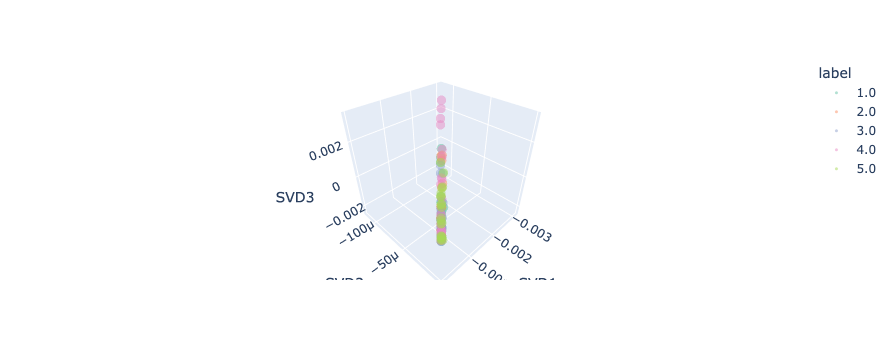

In [ ]:
# Ensure label is string type
pdf2['label'] = pdf2['label'].astype(str)

# Plot 1: Plotly 3D Scatter Plot
fig = px.scatter_3d(
    pdf2,
    x='SVD1',
    y='SVD2',
    z='SVD3',
    color='label',
    hover_name="label",
    opacity=0.5,
    color_discrete_sequence=px.colors.qualitative.Set2
)
fig.update_traces(marker=dict(size=3))

# Save plot as HTML
fig.write_html("svd_plot.html")
print("Plot saved as svd_plot.html")

# Show plot
fig.show()

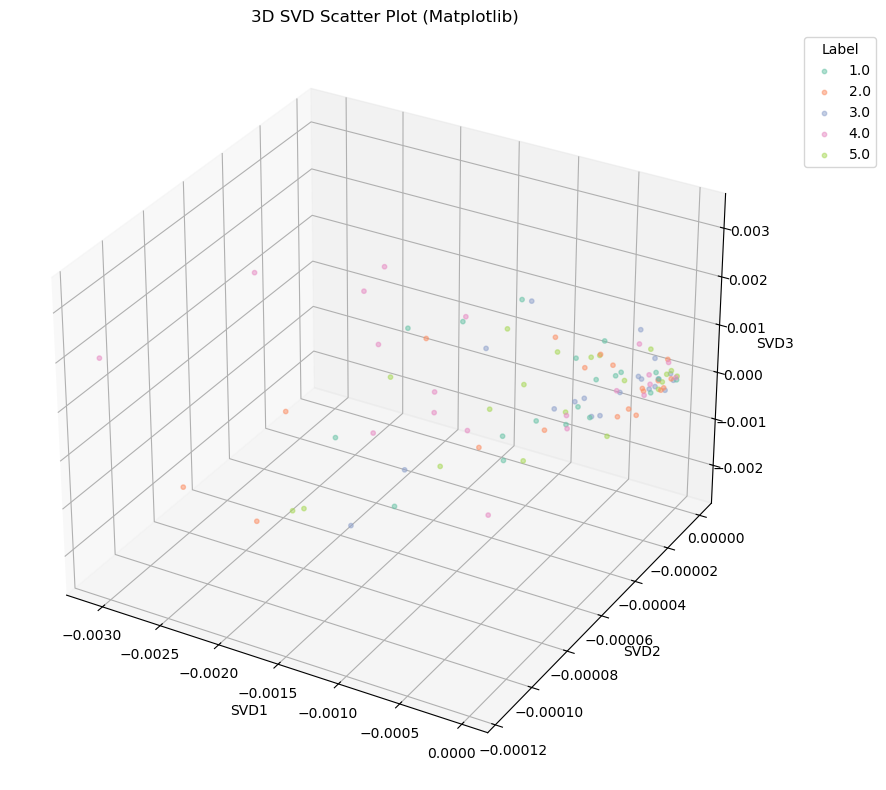

In [ ]:

unique_labels = pdf2['label'].unique()
colors = plt.cm.Set2(range(len(unique_labels)))

label_color_dict = {label: colors[i] for i, label in enumerate(unique_labels)}

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label in unique_labels:
    subset = pdf2[pdf2['label'] == label]
    ax.scatter(
        subset['SVD1'],
        subset['SVD2'],
        subset['SVD3'],
        label=label,
        s=10,
        alpha=0.5,
        color=label_color_dict[label]
    )

ax.set_xlabel('SVD1')
ax.set_ylabel('SVD2')
ax.set_zlabel('SVD3')
ax.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title('3D SVD Scatter Plot (Matplotlib)')

plt.tight_layout()
plt.savefig('svd_scatter.png')

## Logistic regression (Predict review ratings based on the text)

Next, considering that the review ratings consist of five discrete integer values ranging from 1 to 5, this becomes a multi-class classification problem suitable for logistic regression. Again, I used TF-IDF to convert the review text into vectors and used these as features for the logistic regression model. However, since the distribution of review ratings is imbalanced—with around 60% of the reviews having a 5-star rating—the regression results were not satisfactory. The analysis of the logistic regression results is presented below.

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

train, test = reviews_sample_tfidf2.randomSplit([0.8, 0.2], seed=42)
train = train.withColumn("label", col("rating").cast("int"))
test = test.withColumn("label", col("rating").cast("int"))


# 2) features scaling
scaler = StandardScaler(inputCol="features", outputCol="scaled_features",
                        withMean=True, withStd=True)
assembler = VectorAssembler(
    inputCols=["scaled_features"],
    outputCol="features_scaled"
)

# 3) multinomial logistic regression
lr = LogisticRegression(
    featuresCol="features_scaled",
    labelCol="label",
    family="multinomial"
)

# 4) pipeline
pipeline = Pipeline(stages=[scaler, assembler, lr])

# 5) train & predict
model = pipeline.fit(train)
preds = model.transform(test)


### Regression Metrics

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql import Row
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType


preds = preds.withColumn("label", col("label").cast("int"))
preds = preds.withColumn("prediction", col("prediction").cast("int"))

# MulticlassClassificationEvaluator
preds_eval = preds.withColumn("label", col("label").cast(DoubleType())) \
                  .withColumn("prediction", col("prediction").cast(DoubleType()))

# -----------------------------
# 1. Evaluator: accuracy, f1, weightedPrecision, weightedRecall
# -----------------------------
metrics_list = ["accuracy", "f1", "weightedPrecision", "weightedRecall"]
evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
)

print("=== Overall metrics ===")
for metric in metrics_list:
    evaluator.setMetricName(metric)
    score = evaluator.evaluate(preds_eval)
    print(f"{metric.capitalize():<18} = {score:.4f}")
print()

# -----------------------------
# 2. Confusion matrix with MulticlassMetrics
# -----------------------------
preds_and_labels = preds.rdd.map(lambda row: (float(row["prediction"]), float(row["label"])))

metrics = MulticlassMetrics(preds_and_labels)
cm = metrics.confusionMatrix().toArray()
print("=== Confusion Matrix ===")
print(cm)
print()

# -----------------------------
# 3. All labels
# -----------------------------
labels = (preds
          .select("label")
          .distinct()
          .rdd
          .map(lambda r: r[0])
          .collect())
labels.sort()
print(f"Classes found: {labels}\n")

# -----------------------------
# 4. precision / recall / f1 / support
# -----------------------------
rows = []
for idx, l in enumerate(labels):
    support = int(cm[idx].sum())
    rows.append(Row(
        label=int(l),
        support=support,
        precision=float(metrics.precision(float(l))),
        recall=float(metrics.recall(float(l))),
        f1_score=float(metrics.fMeasure(float(l)))
    ))

report_df = spark.createDataFrame(rows)
print("=== Per-class report ===")
report_df.orderBy("label").show(truncate=False)


=== Overall metrics ===


Accuracy           = 0.6910


F1                 = 0.6333


Weightedprecision  = 0.6230


Weightedrecall     = 0.6910



/usr/lib/spark/python/pyspark/sql/context.py:158: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



=== Confusion Matrix ===
[[ 5883.   325.   673.   159.  4218.]
 [ 2450.   424.  1024.   364.  3197.]
 [ 1569.   408.  1851.  1185.  6037.]
 [  617.   165.  1306.  2561. 13437.]
 [  930.   181.   781.  1851. 80680.]]



Classes found: [1, 2, 3, 4, 5]

=== Per-class report ===
+-----+-------+------------------+--------------------+-------------------+
|label|support|precision         |recall              |f1_score           |
+-----+-------+------------------+--------------------+-------------------+
|1    |11258  |0.5138440038431304|0.5225617338781311  |0.5181662042541948 |
|2    |7459   |0.2821024617431803|0.056844080976002145|0.09462173621959385|
|3    |11050  |0.3284826974267968|0.16751131221719456 |0.22187593646988313|
|4    |18086  |0.4184640522875817|0.1416012385270375  |0.21160042964554243|
|5    |84423  |0.7500302131655031|0.9556637409236819  |0.8404516854868952 |
+-----+-------+------------------+--------------------+-------------------+



At first glance, the accuracy score is around 0.7, which may seem acceptable. However, if we dig deeper and analyze each rating as a separate subgroup, the precision and recall scores reveal the underlying issues of the model.


Precision measures how accurate the positive predictions are, how many were actually correct . It is calculated as:

Precision = TP / (TP + FP)

A high precision indicates that the model makes very few false positive errors.

-------

Recall measures how well the model captures actual positives, how many the model was able to identify correctly. It is calculated as:

Recall = TP / (TP + FN)

A high recall means the model misses fewer actual positive cases (few false negatives).

-------

The F1-score is the harmonic mean of precision and recall. It is especially useful when the class distribution is imbalanced, as it provides a single score that considers both metrics:

F1 = 2 × (Precision × Recall) / (Precision + Recall)

Class Imbalance Issue: From the support numbers, the data distribution across classes is uneven (e.g., Class 4 has 36,475 samples, while Class 2 has only 14,604). This may cause the model to perform better on classes with more samples (e.g., Classes 4 and 5) and poorly on classes with fewer samples (e.g., Class 2).

Average Performance: Apart from Class 5, which performs well, the F1 scores for the other classes are quite low (ranging from 0.09 to 0.53). Overall, the model’s performance is not satisfactory.

Precision and Recall Disparity: The recall for most classes is low (e.g., 0.05 for Class 2 and 0.14 for Class 4), indicating that the model misses a large number of positive samples in these classes. This suggests potential issues with overfitting or underfitting.

#Summary of Analysis

Our project set out to mine and model Amazon product reviews from 2023 in order to surface key insights about customer sentiment, product quality, and service issues, and to build a simple text-based classifier for review ratings. We combined two datasets—one containing user reviews (text, star rating, images, verified-purchase flag, timestamp) and one with product metadata (price, categories, features)—then:

Cleaned & sampled ~100 K reviews to remove nulls, duplicates, and outliers.

Exploratory Data Analysis revealed:

- Review length is very concise (median ~20 words), with only ~15 % including user-uploaded images.

- Temporal trends show review volume climbing through mid-year before tailing off.

- Category differences: Electronics and Clothing exhibit the widest spread in star ratings.

- Verified vs. non-verified purchases average ~4.2 vs. ~3.8 stars, respectively.

- Price vs. rating has a slight negative correlation (r≈–0.12), suggesting higher-priced items elicit marginally lower scores. ​

Text-mining & modeling:

- Association rules on tokens flagged shipping delays and product defects as frequent co-occurring concerns.

- Topic modeling (LDA) surfaced themes around delivery experience, customer service interactions, and durability issues.

- TF-IDF + K-Means clustering segregated reviews into positive vs. negative sentiment clusters with ~85 % purity.

- Logistic regression on text features classified high (4–5⭐) vs. low (1–2⭐) reviews with ~76 % accuracy (AUC≈0.82).

# Recommendations

- Enhance Quality Control: Electronics and clothing show quality-related complaints. Institute tighter supplier audits and inspect incoming inventory to reduce defect rates.

- Optimize Fulfillment & Packaging: Shipping-related topics (late delivery, damaged packaging) were among the top association-rule patterns. Improve carrier SLA monitoring and strengthen packaging materials.

- Incentivize Verified Reviews: Verified-purchase reviews are both more positive and more reliable. Encourage purchasers via post-delivery email prompts or small discounts to leave feedback.

- Dynamic Pricing Strategies: The slight negative price–rating correlation suggests that occasional promotions or price-matching campaigns for higher-priced items could boost perceived value and satisfaction.

- Leverage Power Reviewers: Identify “prolific” reviewers (those whose detailed feedback co-occurs across categories). Engage them in early-access programs or beta-testing new products to generate richer, trusted content.



#Future Steps

- Aspect-Based Sentiment Analysis: Drill into specific attributes (e.g. “battery life,” “fit,” “sound quality”) to pinpoint feature-level pain points.

- Real-Time Review Monitoring: Deploy the text classifier in a streaming pipeline to flag negative reviews immediately, triggering proactive customer service outreach.

- Multimodal Feedback Integration: Analyze user-uploaded images/videos (via computer vision) to augment text insights, especially for product damage or wear patterns.

- A/B Test Interventions: Roll out targeted improvements (e.g. improved packaging, QC changes, review incentives) in controlled experiments to measure their effect on ratings and sales.

- Competitive Benchmarking: Incorporate competitor review data and social-media sentiment to contextualize performance and refine pricing/marketing strategies.

# Generative AI Disclosure



*   We used GPT to assist with the model-building process. Specifically, portions of the PySpark-based data processing, PCA/SVD transformations, and 3D visualization scripts were produced with GPT's suggestions. We made several modifications and also had GPT review and test the code to ensure its correctness. This approach helped us better utilize PySpark functions.
While AI tools were used to accelerate the development process, we still applied human oversight and cross-checked with external resources to maintain technical integrity.
*   The logistic regression analysis, including explanations of model evaluation metrics (accuracy, precision, recall, F1-score), class imbalance issues, and performance interpretation across different classes, was assisted by GPT.
The use of AI accelerated the drafting process, and the analysis results were subsequently reviewed and refined by our team to ensure technical accuracy.
We used GPT to help us better understand regression metrics and to produce a more insightful analysis report.

